In [16]:
#Importing Libraries
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from torch.utils.tensorboard import SummaryWriter
from sklearn.manifold import TSNE
from torch.optim.lr_scheduler import StepLR
import time

import warnings
warnings.filterwarnings("ignore")

In [17]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.ColorJitter()
])

full_dataset = datasets.ImageFolder('/kaggle/input/data-set2/data_2', transform=transform)
class_counts = {class_name: 0 for class_name in full_dataset.classes}
for _, index in full_dataset.samples:
    class_name = full_dataset.classes[index]
    class_counts[class_name] += 1
print("Total number of classes:", len(full_dataset.classes))
print("Class names:", full_dataset.classes)
print("Number of images per class:")
for class_name, count in class_counts.items():
    print(f" - {class_name}: {count}")

Total number of classes: 20
Class names: ['antelope', 'bat', 'bee', 'boar', 'butterfly', 'cat', 'cow', 'crab', 'deer', 'dog', 'elephant', 'goldfish', 'hippopotamus', 'horse', 'jellyfish', 'lizard', 'mouse', 'owl', 'penguin', 'pig']
Number of images per class:
 - antelope: 60
 - bat: 60
 - bee: 60
 - boar: 60
 - butterfly: 60
 - cat: 60
 - cow: 60
 - crab: 60
 - deer: 60
 - dog: 60
 - elephant: 60
 - goldfish: 60
 - hippopotamus: 60
 - horse: 60
 - jellyfish: 60
 - lizard: 60
 - mouse: 60
 - owl: 60
 - penguin: 60
 - pig: 60


In [18]:
train_size = int(0.8 * len(full_dataset))
test_validation_size = len(full_dataset) - train_size
validation_size = test_validation_size // 2
test_size = test_validation_size - validation_size

train_dataset, test_validation_dataset = random_split(full_dataset, [train_size, test_validation_size])
validation_dataset, test_dataset = random_split(test_validation_dataset, [validation_size, test_size])

print("Size of the entire Dataset: ", len(full_dataset))
print("Size of the training Dataset: ", len(train_dataset))
print("Size of the validation Dataset: ", len(validation_dataset))
print("Size of the test Dataset: ", len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Size of the entire Dataset:  1200
Size of the training Dataset:  960
Size of the validation Dataset:  120
Size of the test Dataset:  120


In [19]:
googlenet = models.googlenet(pretrained=False, aux_logits=False)
googlenet.fc = torch.nn.Linear(googlenet.fc.in_features, 20)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
googlenet.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(googlenet.parameters(), lr=0.001, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
writer = SummaryWriter()

In [20]:
patience = 5
best_val_loss = np.inf
patience_counter = 0
epochs = 25
for epoch in range(epochs):
    epoch_start_time = time.time()
    train_loss = 0.0
    train_correct = 0
    total_train = 0
    googlenet.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = googlenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / total_train
    writer.add_scalar('Loss/Train', train_loss / len(train_loader), epoch)
    writer.add_scalar('Accuracy/Train', train_accuracy, epoch)

    googlenet.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = googlenet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / total_val
    writer.add_scalar('Loss/Validation', val_loss / len(validation_loader), epoch)
    writer.add_scalar('Accuracy/Validation', val_accuracy, epoch)

    if val_loss / len(validation_loader) < best_val_loss:
        best_val_loss = val_loss / len(validation_loader)
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    scheduler.step()
    print(f"Epoch {epoch+1}: Train Loss: {train_loss / len(train_loader):.4f}, "
      f"Train Accuracy: {train_accuracy:.2f}%, "
      f"Val Loss: {val_loss / len(validation_loader):.4f}, "
      f"Val Accuracy: {val_accuracy:.2f}%")
writer.close()

Epoch 1: Train Loss: 2.8520, Train Accuracy: 12.92%, Val Loss: 3.0506, Val Accuracy: 5.83%
Epoch 2: Train Loss: 2.4895, Train Accuracy: 25.94%, Val Loss: 2.8935, Val Accuracy: 10.83%
Epoch 3: Train Loss: 2.3168, Train Accuracy: 29.17%, Val Loss: 2.5755, Val Accuracy: 22.50%
Epoch 4: Train Loss: 2.1620, Train Accuracy: 36.04%, Val Loss: 2.3950, Val Accuracy: 30.00%
Epoch 5: Train Loss: 2.1504, Train Accuracy: 34.90%, Val Loss: 2.7616, Val Accuracy: 15.83%
Epoch 6: Train Loss: 1.9503, Train Accuracy: 42.92%, Val Loss: 2.2536, Val Accuracy: 35.00%
Epoch 7: Train Loss: 1.8415, Train Accuracy: 46.88%, Val Loss: 2.1771, Val Accuracy: 36.67%
Epoch 8: Train Loss: 1.8077, Train Accuracy: 49.38%, Val Loss: 2.1641, Val Accuracy: 34.17%
Epoch 9: Train Loss: 1.7707, Train Accuracy: 48.96%, Val Loss: 2.1731, Val Accuracy: 35.83%
Epoch 10: Train Loss: 1.7209, Train Accuracy: 50.10%, Val Loss: 2.1456, Val Accuracy: 38.33%
Epoch 11: Train Loss: 1.6923, Train Accuracy: 51.67%, Val Loss: 2.1139, Val Accu

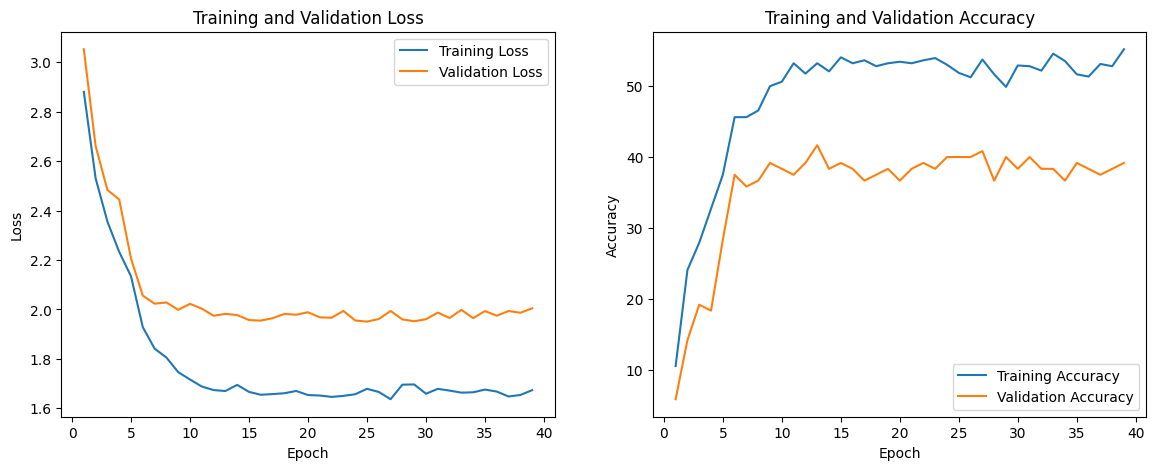

In [21]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

log_dir = '/kaggle/working/runs/Apr09_14-30-09_618905bf21b3'
event_acc = EventAccumulator(log_dir)
event_acc.Reload()

def extract_scalar(event_acc, tag):
    if tag in event_acc.Tags()['scalars']:
        return [scalar.value for scalar in event_acc.Scalars(tag)]
    else:
        return []

train_losses = extract_scalar(event_acc, 'Loss/Train')
train_accuracies = extract_scalar(event_acc, 'Accuracy/Train')
val_losses = extract_scalar(event_acc, 'Loss/Validation')
val_accuracies = extract_scalar(event_acc, 'Accuracy/Validation')
test_losses = extract_scalar(event_acc, 'Loss/Test')
test_accuracies = extract_scalar(event_acc, 'Accuracy/Test')
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
if test_losses:
    plt.axhline(y=test_losses[0], color='r', linestyle='-', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
if test_accuracies:
    plt.axhline(y=test_accuracies[0], color='r', linestyle='-', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

Test Accuracy: 34.17%


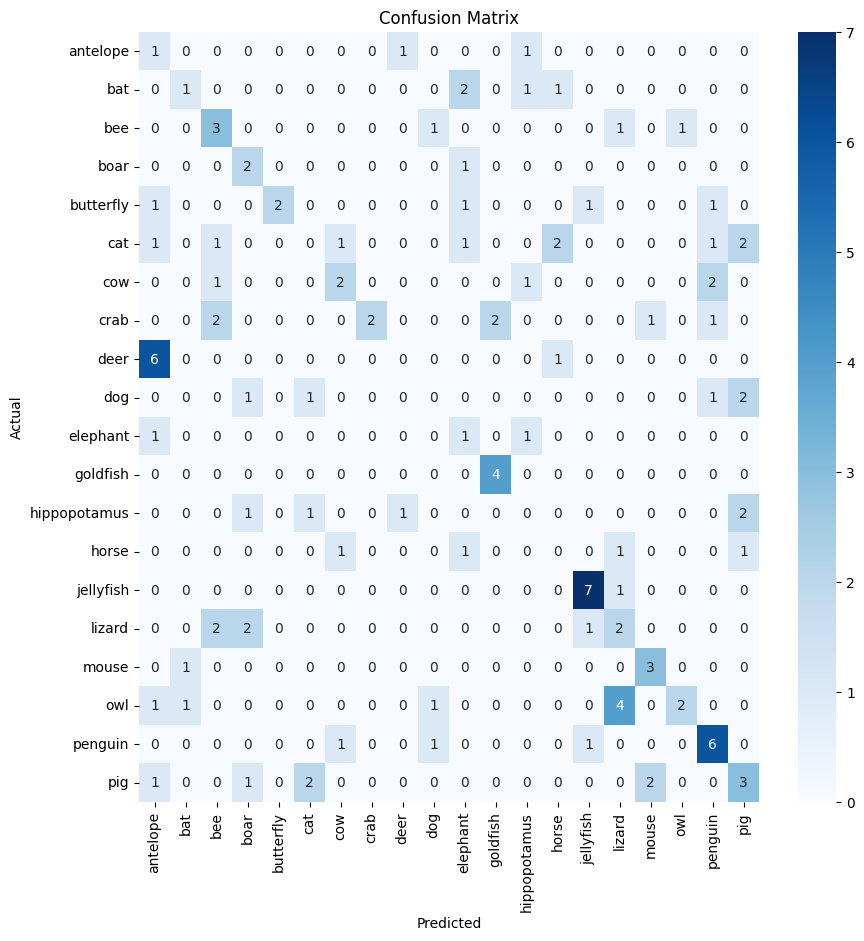

In [22]:
from sklearn.metrics import accuracy_score
googlenet.eval()
true_labels = []
predicted_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = googlenet(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"\033[1mTest Accuracy: {accuracy * 100:.2f}%\033[0m")
conf_mat = confusion_matrix(true_labels, predicted_labels)
class_report = classification_report(true_labels, predicted_labels, target_names=full_dataset.classes, output_dict=True)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues',
            xticklabels=full_dataset.classes,
            yticklabels=full_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [23]:
print("\n\033[1mClassification Report:\033[0m")
print(classification_report(true_labels, predicted_labels, target_names=full_dataset.classes))


Classification Report:
              precision    recall  f1-score   support

    antelope       0.08      0.33      0.13         3
         bat       0.33      0.20      0.25         5
         bee       0.33      0.50      0.40         6
        boar       0.29      0.67      0.40         3
   butterfly       1.00      0.33      0.50         6
         cat       0.00      0.00      0.00         9
         cow       0.40      0.33      0.36         6
        crab       1.00      0.25      0.40         8
        deer       0.00      0.00      0.00         7
         dog       0.00      0.00      0.00         5
    elephant       0.14      0.33      0.20         3
    goldfish       0.67      1.00      0.80         4
hippopotamus       0.00      0.00      0.00         5
       horse       0.00      0.00      0.00         4
   jellyfish       0.70      0.88      0.78         8
      lizard       0.22      0.29      0.25         7
       mouse       0.50      0.75      0.60         4
   

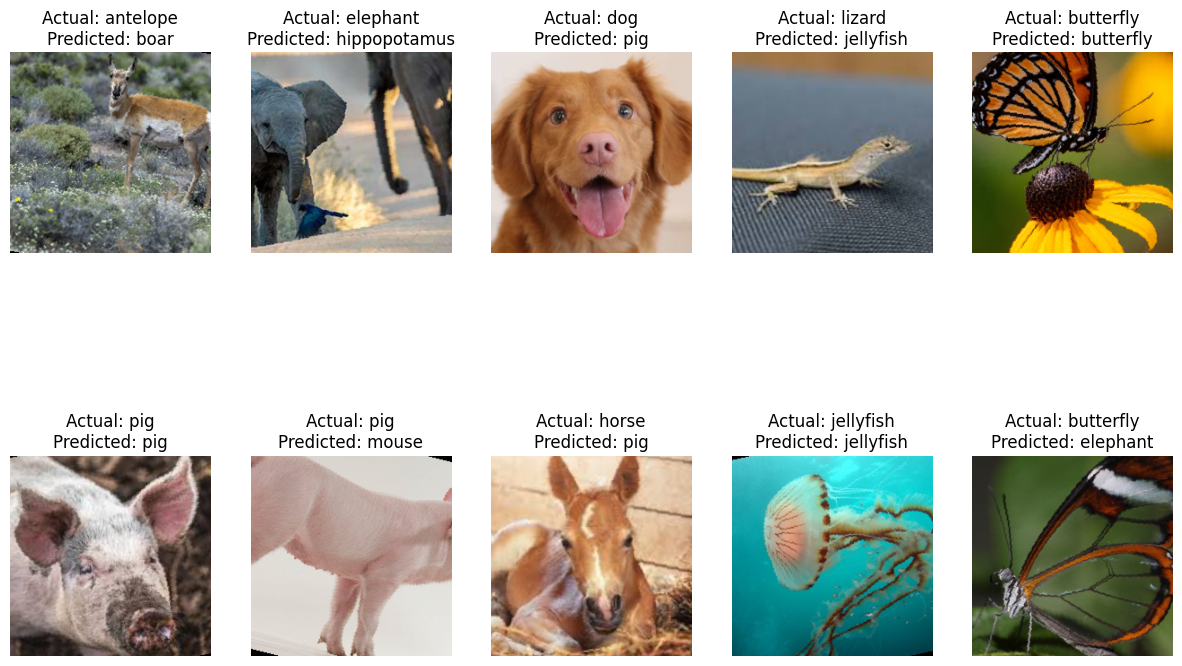

In [24]:
def imshow_with_labels(images, labels, predicted_labels):
    """Display images with labels."""
    fig, axs = plt.subplots(2, 5, figsize=(15, 10))
    fig.subplots_adjust(hspace=0.1)
    axs = axs.flatten()
    for i in range(len(images)):
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        axs[i].imshow(img)
        axs[i].set_title(f'Actual: {full_dataset.classes[labels[i]]}\nPredicted: {predicted_labels[i]}')
        axs[i].axis('off')
    plt.show()
images, labels = next(iter(test_loader))
num_images = 10
images_to_show = images[:num_images]
labels_to_show = labels[:num_images]
images_to_show = images_to_show.to(device)
outputs = googlenet(images_to_show)
_, preds = torch.max(outputs, 1)
predicted_labels = [full_dataset.classes[pred] for pred in preds]
imshow_with_labels(images_to_show, labels_to_show, predicted_labels)